# Load Libraries

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Loading External Data
1. Model and Brand Details
2. Attributes Data
3. Aspirational Data

In [2]:
#import models data
model_details = pd.read_csv("models.csv")
model_details.head()

,brand,model
0,acura,integra
1,acura,Legend
2,acura,vigor
3,acura,rlx
4,acura,ILX


In [3]:
# import attributes data
attributes = pd.read_csv("attributes.csv")
attributes.head()

,category,word
0,cost,price
1,cost,value
2,cost,warranty
3,performance,engine
4,performance,power


In [4]:
# import aspirational data
aspirational = pd.read_csv("aspirational.csv")
aspirational.head()

,category,word
0,aspirational,buy
1,aspirational,sale
2,aspirational,consider
3,aspirational,dealer
4,aspirational,offer


# Data Scrapping

In [5]:
url = 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0'
page = requests.get(url)
soup = BeautifulSoup(page.text, "html.parser")

# extract info from each comment and save to a dataframe
df = pd.DataFrame(columns=["Counter", "Date", "User", "Comment"])
total_comment = 5000 # input

In [6]:
counter = 1
while (counter <= total_comment):
    parents = soup.find_all("div", class_ = "Comment") # scrape all comments
    for item in parents:
        user = item.find("span", class_="Author").text # get userid
        date = item.find("span", class_="MItem DateCreated").find("time").attrs['title'] # get date
        comment = item.find("div", class_="Message userContent").text # get comment
        df = df.append({"Counter":counter,"Date":date, 'User':user,'Comment':comment},ignore_index=True) # append to dataframe
        counter += 1
    # move to next page
    next_button = soup.find("span", class_="BeforeCommentHeading")
    next_page_link = next_button.find("a",{"class":"Next"}).attrs['href']
    page = requests.get(next_page_link)
    soup = BeautifulSoup(page.text, 'html.parser')

df.to_csv("edmunds_extraction.csv",index=False)

In [7]:
df.head(2)

,Counter,Date,User,Comment
0,1,"April 11, 2007 6:52PM",\nmotownusa,\nHi Pat:You forgot the Chrysler Sebring
1,2,"April 11, 2007 7:33PM",\nexshoman,\nI'm sure some folks would appreciate having ...


In [8]:
df.shape

(5000, 4)

# Preprocessing I

In [9]:
# Drop any rows with null values
df.dropna(axis=0, inplace=True)
df.shape

(5000, 4)

In [10]:
#expand contraction words
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['Comment1'] = df.apply(lambda row : decontracted(row['Comment']), axis = 1)

In [11]:
df.head()

,Counter,Date,User,Comment,Comment1
0,1,"April 11, 2007 6:52PM",\nmotownusa,\nHi Pat:You forgot the Chrysler Sebring,\nHi Pat:You forgot the Chrysler Sebring
1,2,"April 11, 2007 7:33PM",\nexshoman,\nI'm sure some folks would appreciate having ...,\nI am sure some folks would appreciate having...
2,3,"April 12, 2007 6:51AM",\ntargettuning,\nYou can try to revive this topic but without...,\nYou can try to revive this topic but without...
3,4,"April 12, 2007 8:43AM",\npat,\nModel vs. model is exactly what we're here f...,\nModel vs. model is exactly what we are here ...
4,5,"April 13, 2007 11:49AM",\nperna,\nThe Altima is my favorite of the bunch. It i...,\nThe Altima is my favorite of the bunch. It i...


In [12]:
#Tokenization the comments column
def token_(x):
    token = word_tokenize(x)
    return token
df['Comment_token'] = df.apply(lambda row : token_(row['Comment1']), axis = 1)

In [13]:
# Lower Casing the Tokenized comments
def lower_case(x):
    ret = []
    for words in x:
        words = words.lower()
        ret.append(words)
    return ret 
df['Comment_token'] = df.apply(lambda row : lower_case(row['Comment_token']), axis = 1)

In [14]:
df.head()

,Counter,Date,User,Comment,Comment1,Comment_token
0,1,"April 11, 2007 6:52PM",\nmotownusa,\nHi Pat:You forgot the Chrysler Sebring,\nHi Pat:You forgot the Chrysler Sebring,"[hi, pat, :, you, forgot, the, chrysler, sebring]"
1,2,"April 11, 2007 7:33PM",\nexshoman,\nI'm sure some folks would appreciate having ...,\nI am sure some folks would appreciate having...,"[i, am, sure, some, folks, would, appreciate, ..."
2,3,"April 12, 2007 6:51AM",\ntargettuning,\nYou can try to revive this topic but without...,\nYou can try to revive this topic but without...,"[you, can, try, to, revive, this, topic, but, ..."
3,4,"April 12, 2007 8:43AM",\npat,\nModel vs. model is exactly what we're here f...,\nModel vs. model is exactly what we are here ...,"[model, vs., model, is, exactly, what, we, are..."
4,5,"April 13, 2007 11:49AM",\nperna,\nThe Altima is my favorite of the bunch. It i...,\nThe Altima is my favorite of the bunch. It i...,"[the, altima, is, my, favorite, of, the, bunch..."


# Model-Brand Data

**Replacing all model names with brand names**

In [15]:
#Lowercasing the model and brand names

def lower(x):
    l = x.lower()
    return l
# Applying the 'lower' function to model_details dataframe in both the columns
model_details['brand'] = model_details.apply(lambda row : lower(row['brand']), axis = 1)
model_details['model'] = model_details.apply(lambda row : lower(row['model']), axis = 1)

In [16]:
#Replacing the model names with brand names
for i in range(len(df)):
    for j in range(len(df['Comment_token'][i])):
        if df['Comment_token'][i][j] in model_details['model'].tolist():
            df['Comment_token'][i][j] = model_details['brand'][model_details['model'].tolist().index(df['Comment_token'][i][j])]

In [17]:
df.head()

,Counter,Date,User,Comment,Comment1,Comment_token
0,1,"April 11, 2007 6:52PM",\nmotownusa,\nHi Pat:You forgot the Chrysler Sebring,\nHi Pat:You forgot the Chrysler Sebring,"[hi, pat, :, you, forgot, the, chrysler, chrys..."
1,2,"April 11, 2007 7:33PM",\nexshoman,\nI'm sure some folks would appreciate having ...,\nI am sure some folks would appreciate having...,"[i, am, sure, some, folks, would, appreciate, ..."
2,3,"April 12, 2007 6:51AM",\ntargettuning,\nYou can try to revive this topic but without...,\nYou can try to revive this topic but without...,"[you, can, try, to, revive, this, topic, but, ..."
3,4,"April 12, 2007 8:43AM",\npat,\nModel vs. model is exactly what we're here f...,\nModel vs. model is exactly what we are here ...,"[model, vs., model, is, exactly, what, we, are..."
4,5,"April 13, 2007 11:49AM",\nperna,\nThe Altima is my favorite of the bunch. It i...,\nThe Altima is my favorite of the bunch. It i...,"[the, nissan, is, my, favorite, of, the, bunch..."


# Text Preprocessing II

In [18]:
# Removing Punctuation
import re 
punctutation = re.compile(r'[-.?!,:;()%\/|0-9""]')
def post_punctutation(x):
    ret = []
    for words in x:
        item = punctutation.sub("",words)
        if len(item)>0:
            ret.append(item)
    return ret 
df['Comment_token_punct'] = df.apply(lambda row : post_punctutation(row['Comment_token']), axis = 1)
len(df['Comment_token_punct'][0]), len(df['Comment_token'][0])

(7, 8)

In [19]:
#Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(x):
    filtered_sentence = []  
    for w in x:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence
df['Comment_token_punct_stopwords'] = df.apply(lambda row : remove_stopwords(row['Comment_token_punct']), axis = 1)
len(df['Comment_token_punct_stopwords'][0]),len(df['Comment_token_punct'][0]),

(5, 7)

## Note:
***I added POS Tagging at this stage of pre-processing because it helps with the Lemmatization, and makes it more accurate. For instance, if we just lemmatize here, the word 'forgot' stays as 'forgot'. But if we do POS tagging first, then lemmatize, it changes to the root word 'forget'.***

In [20]:
#POS Tagging
nltk.download('averaged_perceptron_tagger')
df['pos_tags'] = df['Comment_token_punct_stopwords'].apply(nltk.tag.pos_tag)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [21]:
#wordnet POS - this gives us more accurate lammetization

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [22]:
#Lammetization
wnl = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [23]:
# ALl the duplicate words will be removed from the text/comments including all the adjectives and verbs.
def unique_(test_list):
    res = [] 
    for i in test_list: 
        if i not in res: 
            res.append(i) 
    return res
df['Comment_token_punct_stopwords_unique'] = df.apply(lambda row : unique_(row['lemmatized']), axis = 1)
len(df['Comment_token_punct_stopwords_unique'][0]),len(df['lemmatized'][0]),

(4, 5)

In [24]:
df.head()

,Counter,Date,User,Comment,Comment1,Comment_token,Comment_token_punct,Comment_token_punct_stopwords,pos_tags,wordnet_pos,lemmatized,Comment_token_punct_stopwords_unique
0,1,"April 11, 2007 6:52PM",\nmotownusa,\nHi Pat:You forgot the Chrysler Sebring,\nHi Pat:You forgot the Chrysler Sebring,"[hi, pat, :, you, forgot, the, chrysler, chrys...","[hi, pat, you, forgot, the, chrysler, chrysler]","[hi, pat, forgot, chrysler, chrysler]","[(hi, NN), (pat, NN), (forgot, VBD), (chrysler...","[(hi, n), (pat, n), (forgot, v), (chrysler, n)...","[hi, pat, forget, chrysler, chrysler]","[hi, pat, forget, chrysler]"
1,2,"April 11, 2007 7:33PM",\nexshoman,\nI'm sure some folks would appreciate having ...,\nI am sure some folks would appreciate having...,"[i, am, sure, some, folks, would, appreciate, ...","[i, am, sure, some, folks, would, appreciate, ...","[sure, folks, would, appreciate, chevrolet, in...","[(sure, JJ), (folks, NNS), (would, MD), (appre...","[(sure, a), (folks, n), (would, n), (appreciat...","[sure, folk, would, appreciate, chevrolet, inc...","[sure, folk, would, appreciate, chevrolet, inc..."
2,3,"April 12, 2007 6:51AM",\ntargettuning,\nYou can try to revive this topic but without...,\nYou can try to revive this topic but without...,"[you, can, try, to, revive, this, topic, but, ...","[you, can, try, to, revive, this, topic, but, ...","[try, revive, topic, without, able, discuss, h...","[(try, VB), (revive, JJ), (topic, NN), (withou...","[(try, v), (revive, a), (topic, n), (without, ...","[try, revive, topic, without, able, discus, ho...","[try, revive, topic, without, able, discus, ho..."
3,4,"April 12, 2007 8:43AM",\npat,\nModel vs. model is exactly what we're here f...,\nModel vs. model is exactly what we are here ...,"[model, vs., model, is, exactly, what, we, are...","[model, vs, model, is, exactly, what, we, are,...","[model, vs, model, exactly, manufacturer, vs, ...","[(model, NN), (vs, NN), (model, NN), (exactly,...","[(model, n), (vs, n), (model, n), (exactly, r)...","[model, v, model, exactly, manufacturer, vs, m...","[model, v, exactly, manufacturer, vs, belongs,..."
4,5,"April 13, 2007 11:49AM",\nperna,\nThe Altima is my favorite of the bunch. It i...,\nThe Altima is my favorite of the bunch. It i...,"[the, nissan, is, my, favorite, of, the, bunch...","[the, nissan, is, my, favorite, of, the, bunch...","[nissan, favorite, bunch, amongst, fastest, be...","[(nissan, JJ), (favorite, JJ), (bunch, NN), (a...","[(nissan, a), (favorite, a), (bunch, n), (amon...","[nissan, favorite, bunch, amongst, fast, best,...","[nissan, favorite, bunch, amongst, fast, best,..."


# Frequency Table

In [25]:
#Frequency Distribution
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in df['Comment_token_punct_stopwords_unique'][i]:
        fdist[word]+=1

In [26]:
freq_list = []
for i in range(len(model_details['brand'].unique())):
    if model_details['brand'].unique()[i] in fdist:
        l = model_details['brand'].unique()[i], fdist[model_details['brand'].unique()[i]]
        freq_list.append(l)
freq_table = pd.DataFrame(freq_list,columns=["Model", "Frequency"])
freq_table.sort_values(by = 'Frequency',ascending = False, inplace = True, ignore_index=True)

In [27]:
freq_table

,Model,Frequency
0,honda,2080
1,ford,1344
2,toyota,962
3,hyundai,598
4,mazda,576
5,nissan,564
6,chevrolet,245
7,saturn,245
8,chrysler,221
9,subaru,158


In [28]:
#Top 10 Brands
freq_table.head(10)

,Model,Frequency
0,honda,2080
1,ford,1344
2,toyota,962
3,hyundai,598
4,mazda,576
5,nissan,564
6,chevrolet,245
7,saturn,245
8,chrysler,221
9,subaru,158


# Co-occurrence Matrix

In [29]:
col_req = 10
model_list = freq_table.head(col_req)['Model'].tolist()

In [30]:
model_list

['honda',
 'ford',
 'toyota',
 'hyundai',
 'mazda',
 'nissan',
 'chevrolet',
 'saturn',
 'chrysler',
 'subaru']

In [31]:
cooccur_mat = pd.DataFrame(np.zeros((col_req,col_req)), columns=model_list, index=model_list)

In [32]:
for rows in range(len(df)):
    for i in range(len(model_list)):
        if model_list[i] in df['Comment_token_punct_stopwords_unique'][rows]:
            for j in range(i+1,len(model_list)):
                if model_list[j] in df['Comment_token_punct_stopwords_unique'][rows]:
                    cooccur_mat[model_list[i]][model_list[j]] = cooccur_mat[model_list[i]][model_list[j]] + 1
                    cooccur_mat[model_list[j]][model_list[i]] = cooccur_mat[model_list[i]][model_list[j]]

In [33]:
cooccur_mat

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,saturn,chrysler,subaru
honda,0.0,649.0,686.0,356.0,275.0,339.0,135.0,131.0,126.0,89.0
ford,649.0,0.0,365.0,189.0,182.0,176.0,89.0,88.0,77.0,35.0
toyota,686.0,365.0,0.0,216.0,105.0,242.0,89.0,109.0,53.0,36.0
hyundai,356.0,189.0,216.0,0.0,75.0,108.0,52.0,54.0,43.0,35.0
mazda,275.0,182.0,105.0,75.0,0.0,94.0,28.0,31.0,21.0,59.0
nissan,339.0,176.0,242.0,108.0,94.0,0.0,54.0,77.0,28.0,35.0
chevrolet,135.0,89.0,89.0,52.0,28.0,54.0,0.0,70.0,22.0,12.0
saturn,131.0,88.0,109.0,54.0,31.0,77.0,70.0,0.0,12.0,14.0
chrysler,126.0,77.0,53.0,43.0,21.0,28.0,22.0,12.0,0.0,7.0
subaru,89.0,35.0,36.0,35.0,59.0,35.0,12.0,14.0,7.0,0.0


# Lift Value

In [34]:
lift = pd.DataFrame(np.zeros((col_req,col_req)), columns=model_list, index=model_list)

In [35]:
total = 5000
for i in range(col_req):
    for j in range(col_req):
        lift[model_list[i]][model_list[j]] = total*(cooccur_mat[model_list[i]][model_list[j]]/(freq_table.iloc[i,1]*freq_table.iloc[j,1]))

In [36]:
lift

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,saturn,chrysler,subaru
honda,0.000000,1.160786,1.714177,1.431052,1.147670,1.444865,1.324568,1.285322,1.370519,1.354065
ford,1.160786,0.000000,1.411525,1.175794,1.175492,1.160925,1.351433,1.336249,1.296192,0.824103
toyota,1.714177,1.411525,0.000000,1.877360,0.947462,2.230135,1.888073,2.312359,1.246461,1.184242
hyundai,1.431052,1.175794,1.877360,0.000000,1.088698,1.601082,1.774623,1.842878,1.626841,1.852165
mazda,1.147670,1.175492,0.947462,1.088698,0.000000,1.446759,0.992063,1.098356,0.824849,3.241473
nissan,1.444865,1.160925,2.230135,1.601082,1.446759,0.000000,1.953973,2.786221,1.123199,1.963821
chevrolet,1.324568,1.351433,1.888073,1.774623,0.992063,1.953973,0.000000,5.830904,2.031582,1.549987
saturn,1.285322,1.336249,2.312359,1.842878,1.098356,2.786221,5.830904,0.000000,1.108136,1.808318
chrysler,1.370519,1.296192,1.246461,1.626841,0.824849,1.123199,2.031582,1.108136,0.000000,1.002348
subaru,1.354065,0.824103,1.184242,1.852165,3.241473,1.963821,1.549987,1.808318,1.002348,0.000000


## MDS Plot

In [37]:
mds = 1/lift

In [38]:
mds

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,saturn,chrysler,subaru
honda,inf,0.861485,0.583370,0.698787,0.871331,0.692106,0.754963,0.778015,0.729651,0.738517
ford,0.861485,inf,0.708454,0.850489,0.850708,0.861382,0.739955,0.748364,0.771491,1.213440
toyota,0.583370,0.708454,inf,0.532663,1.055451,0.448403,0.529640,0.432459,0.802272,0.844422
hyundai,0.698787,0.850489,0.532663,inf,0.918528,0.624578,0.563500,0.542630,0.614688,0.539909
mazda,0.871331,0.850708,1.055451,0.918528,inf,0.691200,1.008000,0.910452,1.212343,0.308502
nissan,0.692106,0.861382,0.448403,0.624578,0.691200,inf,0.511778,0.358909,0.890314,0.509211
chevrolet,0.754963,0.739955,0.529640,0.563500,1.008000,0.511778,inf,0.171500,0.492227,0.645167
saturn,0.778015,0.748364,0.432459,0.542630,0.910452,0.358909,0.171500,inf,0.902417,0.553000
chrysler,0.729651,0.771491,0.802272,0.614688,1.212343,0.890314,0.492227,0.902417,inf,0.997657
subaru,0.738517,1.213440,0.844422,0.539909,0.308502,0.509211,0.645167,0.553000,0.997657,inf


In [39]:
#Need to replace 'inf' with zero, otherwise the MDS function does not work
test =  mds.replace(np.inf, 0)

In [40]:
test

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,saturn,chrysler,subaru
honda,0.000000,0.861485,0.583370,0.698787,0.871331,0.692106,0.754963,0.778015,0.729651,0.738517
ford,0.861485,0.000000,0.708454,0.850489,0.850708,0.861382,0.739955,0.748364,0.771491,1.213440
toyota,0.583370,0.708454,0.000000,0.532663,1.055451,0.448403,0.529640,0.432459,0.802272,0.844422
hyundai,0.698787,0.850489,0.532663,0.000000,0.918528,0.624578,0.563500,0.542630,0.614688,0.539909
mazda,0.871331,0.850708,1.055451,0.918528,0.000000,0.691200,1.008000,0.910452,1.212343,0.308502
nissan,0.692106,0.861382,0.448403,0.624578,0.691200,0.000000,0.511778,0.358909,0.890314,0.509211
chevrolet,0.754963,0.739955,0.529640,0.563500,1.008000,0.511778,0.000000,0.171500,0.492227,0.645167
saturn,0.778015,0.748364,0.432459,0.542630,0.910452,0.358909,0.171500,0.000000,0.902417,0.553000
chrysler,0.729651,0.771491,0.802272,0.614688,1.212343,0.890314,0.492227,0.902417,0.000000,0.997657
subaru,0.738517,1.213440,0.844422,0.539909,0.308502,0.509211,0.645167,0.553000,0.997657,0.000000


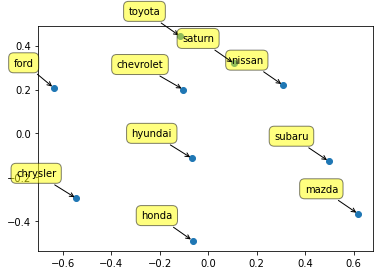

In [41]:
#Create MDS plot
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
results = mds.fit(test)
mds_coords = results.fit_transform(test) 

names = freq_table['Model'] 

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    mds_coords[:, 0], mds_coords[:, 1], marker = 'o'
    )
for label, x, y in zip(names, mds_coords[:, 0], mds_coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()


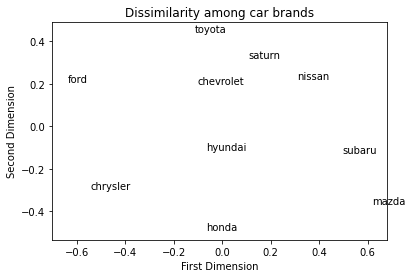

In [42]:
#ANOTHER WAY TO PLOT THE MDS
coords = results.embedding_
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1],
    facecolors = 'none', edgecolors = 'none')  # points in white (invisible)
labels = names
for label, x, y in zip(labels, mds_coords[:,0], mds_coords[:,1]):
    plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among car brands')    
plt.show()

# TASK C & Task D: Attribute Frequencies

In [43]:
#Calculate the frequency of ALL the words in ALL the reviews

from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in df['Comment_token_punct_stopwords_unique'][i]:
        fdist[word]+=1
word_freqs = pd.DataFrame(fdist.items(), columns = ['word', 'frequency']).sort_values(by = ['frequency'], ascending = False)
word_freqs

pd.set_option('display.max_rows', 200)
word_freqs.head(200)

,word,frequency
111,car,2329
88,honda,2080
6,would,1666
102,get,1457
73,like,1409
177,'',1355
71,ford,1344
120,think,1278
175,``,1246
106,one,1233


In [44]:
#word_freqs.to_csv(r"C:\Users\e_wor\Downloads\word_frequency.csv")

In [45]:
#Replace certain related words to form larger attribute categories
for i in range(len(df)):
    for j in range(len(df['Comment_token_punct_stopwords_unique'][i])):
        if df['Comment_token_punct_stopwords_unique'][i][j] in attributes['word'].tolist():
            df['Comment_token_punct_stopwords_unique'][i][j] = attributes['category'][attributes['word'].tolist().index(df['Comment_token_punct_stopwords_unique'][i][j])]


#recount the frequency of all the words
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in df['Comment_token_punct_stopwords_unique'][i]:
        fdist[word]+=1
word_freqs2 = pd.DataFrame(fdist.items(), columns = ['word', 'frequency']).sort_values(by = ['frequency'], ascending = False)
word_freqs2

word_freqs2.head(20)


,word,frequency
110,car,2329
93,performance,2291
82,look,2082
87,honda,2080
6,would,1666
65,cost,1501
101,get,1457
73,like,1409
173,'',1355
71,ford,1344


### Top 5 attributes are:  
-  performance
-  look
-  cost
-  size
-  gas

## Pick 5 most frequently mentioned brands and find the attributes most strongly associated with these brands

In [46]:
#Put the Top 5 Brands and the Top 5 Attributes in one dataframe to prep for Lift Analysis

options = ['performance', 'look', 'cost', 'size', 'gas'] 
top_attributes_tab = word_freqs2.loc[word_freqs2['word'].isin(options)] 

top5brands = ['honda','ford','toyota','hyundai','mazda']
top_5_brands = (freq_table.loc[freq_table['Model'].isin(top5brands)])

results = pd.concat([top_5_brands,top_attributes_tab.rename(columns={'word':'Model', 'frequency':'Frequency'})], ignore_index=True)
results

,Model,Frequency
0,honda,2080
1,ford,1344
2,toyota,962
3,hyundai,598
4,mazda,576
5,performance,2291
6,look,2082
7,cost,1501
8,size,1305
9,gas,1037


In [47]:
#find lift values between top 5 brands and top 5 attributes

#first, create co-occurence matrix
col_req=10
top_brands_attributes = results.head(col_req)['Model'].tolist()

cooccur_mat2 = pd.DataFrame(np.zeros((col_req,col_req)), columns=top_brands_attributes, index=top_brands_attributes)

for rows in range(len(df)):
    for i in range(len(top_brands_attributes)):
        if top_brands_attributes[i] in df['Comment_token_punct_stopwords_unique'][rows]:
            for j in range(i+1,len(top_brands_attributes)):
                if top_brands_attributes[j] in df['Comment_token_punct_stopwords_unique'][rows]:
                    cooccur_mat2[top_brands_attributes[i]][top_brands_attributes[j]] = cooccur_mat2[top_brands_attributes[i]][top_brands_attributes[j]] + 1
                    cooccur_mat2[top_brands_attributes[j]][top_brands_attributes[i]] = cooccur_mat2[top_brands_attributes[i]][top_brands_attributes[j]]
                    

#Lift Values

lift2 = pd.DataFrame(np.zeros((col_req,col_req)), columns=top_brands_attributes, index=top_brands_attributes)

total = 5000
for i in range(col_req):
    for j in range(col_req):
        lift2[top_brands_attributes[i]][top_brands_attributes[j]] = total*(cooccur_mat2[top_brands_attributes[i]][top_brands_attributes[j]]/(results.iloc[i,1]*results.iloc[j,1]))

lift2

,honda,ford,toyota,hyundai,mazda,performance,look,cost,size,gas
honda,0.000000,1.160786,1.714177,1.431052,1.147670,0.687263,0.943296,1.023356,0.943118,0.774238
ford,1.160786,0.000000,1.411525,1.175794,1.175492,0.815172,0.916658,0.810472,0.860929,0.893288
toyota,1.714177,1.411525,0.000000,1.877360,0.947462,0.780420,0.978589,1.080361,1.158984,0.912195
hyundai,1.431052,1.175794,1.877360,0.000000,1.088698,0.620430,1.064226,1.114084,0.935430,0.540213
mazda,1.147670,1.175492,0.947462,1.088698,0.000000,0.863888,1.042334,1.058322,1.137452,0.560846
performance,0.687263,0.815172,0.780420,0.620430,0.863888,0.000000,0.592260,0.555428,0.715778,0.888134
look,0.943296,0.916658,0.978589,1.064226,1.042334,0.592260,0.000000,0.702382,0.791311,0.620648
cost,1.023356,0.810472,1.080361,1.114084,1.058322,0.555428,0.702382,0.000000,0.758115,0.648876
size,0.943118,0.860929,1.158984,0.935430,1.137452,0.715778,0.791311,0.758115,0.000000,0.772195
gas,0.774238,0.893288,0.912195,0.540213,0.560846,0.888134,0.620648,0.648876,0.772195,0.000000


# Task E: Brand that people want to buy/own


In [48]:
#Replacing the words that show interest in buying or purchasing	'buy', 'sale', 'consider, 'dealer' and 'offer'
for i in range(len(df)):
    for j in range(len(df['Comment_token_punct_stopwords_unique'][i])):
        if df['Comment_token_punct_stopwords_unique'][i][j] in aspirational['word'].tolist():
            df['Comment_token_punct_stopwords_unique'][i][j] = aspirational['category'][aspirational['word'].tolist().index(df['Comment_token_punct_stopwords_unique'][i][j])]


#Counting the frequency of the word 'aspirational'
from nltk.probability import FreqDist
fdist = FreqDist()
for i in range(len(df)):
    for word in df['Comment_token_punct_stopwords_unique'][i]:
        fdist[word]+=1
word_freqs3 = pd.DataFrame(fdist.items(), columns = ['word', 'frequency']).sort_values(by = ['frequency'], ascending = False)
aspirational_freq = word_freqs3.loc[word_freqs3['word'].isin(['aspirational'])] 
aspirational_freq

,word,frequency
11,aspirational,3686


In [49]:
#Concatenate table to prep for co-occurence matrix
results2 = pd.concat([freq_table,aspirational_freq.rename(columns={'word':'Model', 'frequency':'Frequency'})], ignore_index=True)
results2

,Model,Frequency
0,honda,2080
1,ford,1344
2,toyota,962
3,hyundai,598
4,mazda,576
5,nissan,564
6,chevrolet,245
7,saturn,245
8,chrysler,221
9,subaru,158


In [50]:
top_aspiration = results2['Model'].to_list()

#Co-occurence Matrix

col_req2 = 27
cooccur_mat3 = pd.DataFrame(np.zeros((col_req2,col_req2)), columns=top_aspiration, index=top_aspiration)

for rows in range(len(df)):
    for i in range(len(top_aspiration)):
        if top_aspiration[i] in df['Comment_token_punct_stopwords_unique'][rows]:
            for j in range(i+1,len(top_aspiration)):
                if top_aspiration[j] in df['Comment_token_punct_stopwords_unique'][rows]:
                    cooccur_mat3[top_aspiration[i]][top_aspiration[j]] = cooccur_mat3[top_aspiration[i]][top_aspiration[j]] + 1
                    cooccur_mat3[top_aspiration[j]][top_aspiration[i]] = cooccur_mat3[top_aspiration[i]][top_aspiration[j]]
                    
#Lift Values
lift3 = pd.DataFrame(np.zeros((col_req2,col_req2)), columns=top_aspiration, index=top_aspiration)

total = 5000
for i in range(col_req2):
    for j in range(col_req2):
        lift3[top_aspiration[i]][top_aspiration[j]] = total*(cooccur_mat3[top_aspiration[i]][top_aspiration[j]]/(results2.iloc[i,1]*results2.iloc[j,1]))
        
lift3

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,saturn,chrysler,subaru,kia,bmw,volkswagen,mercury,dodge,acura,buick,pontiac,mitsubishi,lincoln,audi,volvo,mercedes,cadillac,infiniti,suzuki,aspirational
honda,0.000000,1.160786,1.714177,1.431052,1.147670,1.444865,1.324568,1.285322,1.370519,1.354065,1.274767,1.153846,1.319759,1.185897,1.007017,1.899814,1.081731,1.265182,0.664894,0.534188,0.996717,0.961538,1.157407,0.712251,1.479290,0.801282,0.749327
ford,1.160786,0.000000,1.411525,1.175794,1.175492,1.160925,1.351433,1.336249,1.296192,0.824103,1.127345,0.654762,0.948296,2.827381,1.106017,0.900058,1.178075,0.913743,1.029002,3.472222,0.725900,2.108135,1.240079,0.688933,0.572344,2.066799,0.712558
toyota,1.714177,1.411525,0.000000,1.877360,0.947462,2.230135,1.888073,2.312359,1.246461,1.184242,1.535627,1.704782,1.579634,2.148302,1.194021,1.508953,1.992377,1.914870,0.884682,0.808501,1.521221,1.039501,0.770001,1.155001,2.398849,0.000000,0.807968
hyundai,1.431052,1.175794,1.877360,0.000000,1.088698,1.601082,1.774623,1.842878,1.626841,1.852165,5.130739,1.806020,1.393534,1.895206,1.581849,1.213723,0.696767,1.320190,3.735857,0.743218,1.019659,0.836120,2.167720,0.619348,0.643170,2.787068,0.787124
mazda,1.147670,1.175492,0.947462,1.088698,0.000000,1.446759,0.992063,1.098356,0.824849,3.241473,0.920665,1.319444,1.787173,1.967593,0.703829,1.680108,1.591435,1.522904,2.031619,1.350309,1.482046,2.604167,0.321502,0.964506,1.335470,0.000000,0.751247
nissan,1.444865,1.160925,2.230135,1.601082,1.446759,0.000000,1.953973,2.786221,1.123199,1.963821,1.477541,1.418440,2.520512,2.127660,0.599003,1.429879,2.364066,2.955083,1.320356,0.394011,1.729805,1.477541,0.985028,0.656685,2.727769,2.955083,0.702293
chevrolet,1.324568,1.351433,1.888073,1.774623,0.992063,1.953973,0.000000,5.830904,2.031582,1.549987,1.855288,1.632653,3.001200,2.448980,2.757860,1.316656,6.122449,13.247404,3.039514,0.000000,0.995520,1.360544,2.267574,6.802721,3.139717,0.000000,0.802817
saturn,1.285322,1.336249,2.312359,1.842878,1.098356,2.786221,5.830904,0.000000,1.108136,1.808318,2.628324,1.959184,2.000800,3.537415,1.378930,1.316656,4.761905,9.667025,0.868432,0.453515,1.493280,1.360544,0.755858,6.046863,0.000000,0.000000,0.780670
chrysler,1.370519,1.296192,1.246461,1.626841,0.824849,1.123199,2.031582,1.108136,0.000000,1.002348,2.742356,0.904977,0.887233,1.508296,7.643390,0.364910,1.885370,1.984600,2.888226,1.005530,0.000000,1.508296,0.837942,1.675884,0.000000,5.027652,0.859311
subaru,1.354065,0.824103,1.184242,1.852165,3.241473,1.963821,1.549987,1.808318,1.002348,0.000000,1.917913,1.518987,2.792256,3.375527,1.710571,2.041650,1.582278,2.220742,4.713170,0.703235,0.771843,3.164557,0.000000,0.000000,0.000000,3.516174,0.678242


## The most aspirational brand seems to be *CHRYSLER*
lift value = 0.858845